# Advantage Actor-Critic

Much of this code was adapted from this excellent article on Medium put out by Tensorflow:
https://medium.com/tensorflow/deep-reinforcement-learning-playing-cartpole-through-asynchronous-advantage-actor-critic-a3c-7eab2eea5296

Although they build an Asynchronous Advantage Actor Critic (A3C) model (while we're only building an A2C model), the code they wrote is so clean and intuitive that I was able to adapt it to the much simpler A2C model.  Even more, the article's utilization of Tensorflow's Eager Execution and Model Subclassing makes it possible to really explore how these models work and construct them from the ground up.  It's a pretty good read.

First, we import some useful libraries.

In [216]:
%load_ext autoreload
%autoreload 2
import gym
import time
import numpy as np
import ipywidgets as widgets
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next, we import `tensorflow` as `tf`.  We also import Tensorflow's Keras submodule so that we can build these models with ease using Tensorflow's Model Subclassing.

https://www.tensorflow.org/api_docs/python/tf/keras/models/Model

We enable eager execution so that we can more readily experiment with the models we need.  TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later.

https://www.tensorflow.org/guide/eager

In [2]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.enable_eager_execution(config=config)

In order to build an A2C model, we need to first build the critic model and the actor model.  The critic model is used to approximate the value of any state in an environment, while the actor is used to produce a probability of the actions we can take as the agent.  We can use the critic to determine which actions performed are favorible by calculating their advantage, which will then allow us to train our actor to make those favourable actions more likley.

## Critic Model

First, we define the critic.  This model will recieve the observation as input and will return the value of the given state.
<br>It's initialized with the size of the observation vector and the size of the action vector.
<br>It's comprised of two hidden dense layers of size 128 with relu activations and a dense output layer of size 1.

In [3]:
class CriticModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(CriticModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        
        self.value_dense_1 = layers.Dense(128, activation='relu')
        self.value_dense_2 = layers.Dense(128, activation='relu')
        self.values = layers.Dense(1)

    def call(self, inputs):
        input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
        y = self.value_dense_1(input_tensor)
        y = self.value_dense_2(y)
        values = self.values(y)
        return values

We can quickly test to see if our critic can learn a basic XOR dataset.  First, we create the XOR data and initialize our critic.

In [4]:
input_data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

output_data = np.array([
    [0],
    [1],
    [1],
    [0]
])

critic = CriticModel(len(input_data[0]), len(output_data[0]))

Next, we perform backpropagation to train the critic.  First, we pass the XOR input data through the critic to perform forward propagation, then we calculate the negative MSE of the actual XOR output data and the critic's output.  We perform both of these operations within the `GradientTape` context manager, which records operations for automatic differentiation.  
We can then call the resulting `tape.gradient` method with the loss and weights we want to recieve the gradients for (i.e., the critic's trainable_weights).  This gives us back the gradients as tensors.  We can then iterate through the gradients and the critic's corresponding weights and add the gradients (multiplied by our learning rate `lr`) to the weights.

This will complete one iteration of backpropagation for our critic.  We repeat this process for `epochs` iterations, which should result in fairly accurate results.

https://www.tensorflow.org/api_docs/python/tf/GradientTape

In [5]:
lr = 0.01
epochs = 100

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        values = critic(input_data)
        critic_loss = -tf.reduce_sum((output_data - values)**2)

    critic_grads = tape.gradient(critic_loss, critic.trainable_weights)
    for w, g in zip(critic.trainable_weights, critic_grads):
        w.assign_add(lr * g)
        
print(critic_loss)
print(output_data)
print(values)

tf.Tensor(-0.06462556, shape=(), dtype=float32)
[[0]
 [1]
 [1]
 [0]]
tf.Tensor(
[[0.16791038]
 [0.886855  ]
 [0.8878074 ]
 [0.10508424]], shape=(4, 1), dtype=float32)


The critic will be tasked with learning the value function for our environment.  This means that we will train the critic with the discounted future rewards calculated for every episode, so that we can readily approximate the the value of any given state in our environment.  We will then use this value to train the actor model.

## Actor Model

Next, we define the actor.  This model will recieve the observation as input and will return the probability distribution of the actions for the given state.
<br>It's initialized with the size of the observation vector and the size of the action vector.
<br>It's comprised of two hidden dense layers of size 128 with relu activations and a dense output layer of size `action_size`.

In [6]:
class ActorModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(ActorModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        
        self.policy_dense_1 = layers.Dense(128, activation='relu')
        self.policy_dense_2 = layers.Dense(128, activation='relu')
        self.policy_logits = layers.Dense(action_size)

    def call(self, inputs):
        input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
        x = self.policy_dense_1(input_tensor)
        x = self.policy_dense_2(x)
        logits = self.policy_logits(x)
        return logits

We can now quickly test the model.  We are going to provide pseudo advantage values in order to see if we can train our actor to perform specific actions at specific states.

The observation data our agent will receive will be simple: one of either `[1, 0, 0]`, `[0, 1, 0]`, or `[0, 0, 1]`.  The agent will be given an action size of 3, so that it will produce a probability over 3 actions.

We will reward the actor with +1 if it's chosen action matches the observation and -1 otherwise (e.g., if the observation is `[1, 0, 0]`, then the actor recieves +1 if it chooses the 0th action).

In [275]:
def run_actor_test(state, reward=1):
    print(state)
    observations = [[1,0,0], [0,1,0], [0,0,1]]
    lr = 0.01
    with tf.GradientTape() as tape:
        logits = actor([observations[state]])
        probs = tf.nn.softmax(logits)
        action = np.random.choice(3, p=probs.numpy()[0])
        if action == np.argmax(observations[state]):
            adv = reward
        else:
            adv = -reward
        mask = np.zeros(3)
        mask[action] = adv
        actor_loss = tf.log(probs + 1e-10)*mask

    actor_grads = tape.gradient(actor_loss, actor.trainable_weights)

    for w, ag in zip(actor.trainable_weights, actor_grads):
        w.assign_add(lr*ag)

    # Visualization
    for i, obs in enumerate(observations):
        logits = actor([obs])
        probs = tf.nn.softmax(logits)
        fig.data[i]['y'] = np.array(probs.numpy()[0])

In [290]:
actor = ActorModel(3, 3)

In [293]:
layout = go.Layout(
    title = "Action Probabilites",
    xaxis1 = dict(
        domain=[0, 0.32],
        dtick=1,
    ),
    yaxis = dict(
        anchor='x1',
        range=[0,1]
    ),
    xaxis2 = dict(
        domain=[0.35, 0.65],
        dtick=1,
    ),
    yaxis2 = dict(
        anchor='x2',
        range=[0,1]
    ),
    xaxis3 = dict(
        domain=[0.70, 1],
        dtick=1,
    ),
    yaxis3 = dict(
        anchor='x3',
        range=[0,1]
    ),
)
data = [
    go.Bar(y=np.zeros(3), xaxis='x1', yaxis='y1', name="State 0"),
    go.Bar(y=np.zeros(3), xaxis='x2', yaxis='y2', name="State 1"),
    go.Bar(y=np.zeros(3), xaxis='x3', yaxis='y3', name="State 2")
]
fig = go.FigureWidget(data=data, layout=layout)
fig

FigureWidget({
    'data': [{'name': 'State 0',
              'type': 'bar',
              'uid': 'ba366185-ed…

In [294]:
buttons = []
reward = 10
for state in range(3):
    button = widgets.Button(
        description=f'State {state}',
        state=state
    )
    click_function = lambda state: lambda b: run_actor_test(state, reward)
    button.on_click(click_function(state))
    buttons.append(button)

widgets.Box(buttons)

Box(children=(Button(description='State 0', style=ButtonStyle()), Button(description='State 1', style=ButtonSt…

In [14]:
observations = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

correct_action = np.array([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0]
])

class XOREnv:
    def __init__(self, timesteps=10):
        self.action_space = gym.spaces.MultiBinary(1)
        self.observation_space = gym.spaces.Discrete(2)
        
        self.observations = np.array([
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1]
        ])
        
        self.actions = np.array([
            [1, 0],
            [0, 1],
            [0, 1],
            [1, 0]
        ])
        
        self.timesteps = timesteps

    def reset(self):
        self.timestep = 0
        self.state = np.random.choice(len(self.actions))
        return self.observations[self.state]
    
    def step(self, action):
        if action == np.argmax(self.actions[self.state]):
            reward = 1
        else:
            reward = -1
            
        self.state = np.random.choice(len(self.actions))
        
        self.timestep += 1
        if self.timestep > self.timesteps:
            done = True
        else:
            done = False
            
        if self.timestep + 1 > self.timesteps:
            last_run = True
        else:
            last_run = False
            
        return self.observations[self.state], reward, done, { "last_run": last_run }

In [15]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        
    def step(self, observation):
        return np.random.choice(self.env.action_space.n)

In [16]:
env = XOREnv()
agent = RandomAgent(env)

obs = agent.env.reset()
done = False
step = 0
rewards = []
while not done:
    print(f"{'step':>13}: {step}")
    action = agent.step(obs)
    print(f"{'action':>13}: {action}")
    
    next_obs, reward, done, info = agent.env.step(action)
    print(f"{'next_obs':>13}: {next_obs}")
    print(f"{'reward':>13}: {reward}")
    print(f"{'done':>13}: {done}")
    print(f"{'info':>13}: {info}")
    
    step += 1
    rewards.append(reward)
    total_reward = np.sum(rewards)
    print(f"{'total_reward':>13}: {total_reward}")
    print(f"{'...':>13}\n")
    
print(f" Total Reward: {np.sum(rewards)}"

DEBUG:root:         step: 0
DEBUG:root:       action: 0
DEBUG:root:     next_obs: [1 0]
DEBUG:root:       reward: 1
DEBUG:root:         done: False
DEBUG:root:         info: {'last_run': False}
DEBUG:root: total_reward: 1
DEBUG:root:          ...

INFO:root: Total Reward: 1


In [18]:
class ActorCriticModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(ActorCriticModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        self.actor = ActorModel(observation_size, action_size)
        self.critic = CriticModel(observation_size, action_size)
        
    def call(self, inputs):
        return self.actor(inputs), self.critic(inputs)

class HyperParameters:
    def __init__(self, **kw):
        self.gamma = 0.99
        self.vf_coef = 0.5
        self.ent_coef = 0.01
        self.lr = 0.001
        self.__dict__.update(kw)
        
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [20]:
def loss(a2c, observations, actions, discounted_rewards, hyperparameters, verbose=False, normalize_discounted_rewards=True, *args, **kargs):
    hp = hyperparameters
    
    logits, values = a2c(tf.convert_to_tensor(observations, dtype=tf.float32))
    values = tf.squeeze(values)

    if normalize_discounted_rewards:
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)

    discounted_rewards = tf.convert_to_tensor(np.array(discounted_rewards), dtype=tf.float32)
    advantages =  tf.stop_gradient(discounted_rewards) - values

    critic_loss = advantages ** 2

    policy = tf.nn.softmax(logits)
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=policy, logits=logits)

    actor_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions, logits=logits)
    actor_loss *= tf.stop_gradient(advantages)
    actor_loss -= hp.ent_coef * entropy

    total_loss = tf.reduce_mean(hp.vf_coef * critic_loss + actor_loss)

    if verbose:
        variables = dir()[:]
        for key in variables:
            print(key)
            print(locals()[key])
    
    return total_loss

In [21]:
def run(env, a2c, verbose=False, *args, **kargs):
    obs = env.reset()
    done = False
    rewards = []
    actions = []
    observations = []
        
    while not done:
        logits, _ = a2c(tf.convert_to_tensor(obs[None, :], dtype=tf.float32))
        probs = tf.nn.softmax(logits)
        action = np.random.choice(env.action_space.n, p=probs.numpy()[0])

        next_obs, reward, done, info = env.step(action)
        
        if done:
            reward = -1
        
        observations.append(obs)
        actions.append(action)
        rewards.append(reward)
        
        obs = next_obs
        total_reward = np.sum(rewards)
        
        if verbose:
            variables = dir()[:]
            for key in variables:
                print(key)
                print(locals()[key])
            
        if done:
            return observations, actions, rewards

In [22]:
def get_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    reward_sum = 0
    for reward in rewards[::-1]:
        reward_sum = reward + gamma * reward_sum
        discounted_rewards.append(reward_sum)
    discounted_rewards.reverse()
    return discounted_rewards

In [23]:
def learn(a2c, observations, actions, discounted_rewards, hyperparameters, *args, **kargs):
    opt = tf.train.AdamOptimizer(hp.lr, use_locking=True)
    with tf.GradientTape() as tape:
        total_loss = loss(a2c, observations, actions, discounted_rewards, hyperparameters=hp, **kargs)

    grads = tape.gradient(total_loss, a2c.trainable_weights)
    opt.apply_gradients(zip(grads, a2c.trainable_weights))

In [24]:
env = gym.make('CartPole-v0')
#env = gym.make('LunarLander-v2')
a2c = ActorCriticModel(env.observation_space.shape[0], env.action_space.n)
a2c(tf.convert_to_tensor(np.random.random((1, a2c.state_size)), dtype=tf.float32))

(<tf.Tensor: id=88, shape=(1, 2), dtype=float32, numpy=array([[ 0.03009   , -0.01452742]], dtype=float32)>,
 <tf.Tensor: id=174, shape=(1, 1), dtype=float32, numpy=array([[-0.01758317]], dtype=float32)>)

In [26]:
hp = HyperParameters(gamma = 0.99, vf_coef = 0.5, ent_coef = 0.001, lr = 0.001)

start_time = time.time()
batch = {
    "observations": [],
    "actions": [],
    "discounted_rewards": []
}

ep_rewards = []
episodes = 100
episode = 0
epochs = 8
batch_size = 512
while episode < episodes:
    observations, actions, rewards = run(env, a2c, verbose=0)
    ep_rewards.append(np.sum(rewards))
    
    # Calculate True Discounted Rewards
    discounted_rewards = get_discounted_rewards(rewards, hp.gamma)
    
    batch['observations'] += observations
    batch['actions'] += actions
    batch['discounted_rewards'] += discounted_rewards

    if len(batch['observations']) >= batch_size:
        print(f"Ep {episode} ({time.time() - start_time:.3f}s): {np.mean(ep_rewards[-10:])}")
        for epoch in range(epochs):
            learn(a2c, hyperparameters=hp, lock_actor=True, **batch)
        batch = {
            "observations": [],
            "actions": [],
            "discounted_rewards": []
        }
    episode += 1
    
end_time = time.time()
print(end_time - start_time)

Ep 26 (0.403s): 18.5
Ep 41 (1.129s): 39.0
Ep 52 (1.854s): 51.1
Ep 56 (2.565s): 81.4
Ep 62 (3.290s): 101.8
Ep 66 (4.034s): 105.0
Ep 71 (4.799s): 118.0
Ep 76 (5.566s): 106.6
Ep 79 (6.384s): 129.6
Ep 86 (7.184s): 114.9
Ep 90 (8.103s): 121.2
Ep 93 (8.942s): 159.0
Ep 96 (9.788s): 188.9
10.54092526435852


In [45]:
observations, actions, rewards = run(env, a2c, verbose=False)
discounted_rewards = get_discounted_rewards(rewards, hp.gamma)
learn(a2c, observations, actions, discounted_rewards, hyperparameters=hp, verbose=True)

a2c
actions
[0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1]
actor_loss
tf.Tensor(
[ 1.60148993e-01  4.41398658e-02  1.43281743e-01  4.70659398e-02
  1.32774949e-01  4.90165502e-02  5.98091424e-01  1.81604338e+00
  1.12967473e-02  2.99371146e-02  8.44361782e-02  6.28321245e-02
  7.17442557e-02  7.63893276e-02  6.23220690e-02  6.97361112e-01
  1.21585354e-02  1.09329566e-01  5.41375987e-02  1.19269513e-01
  1.04863775e+00  1.74634736e-02  1.0833

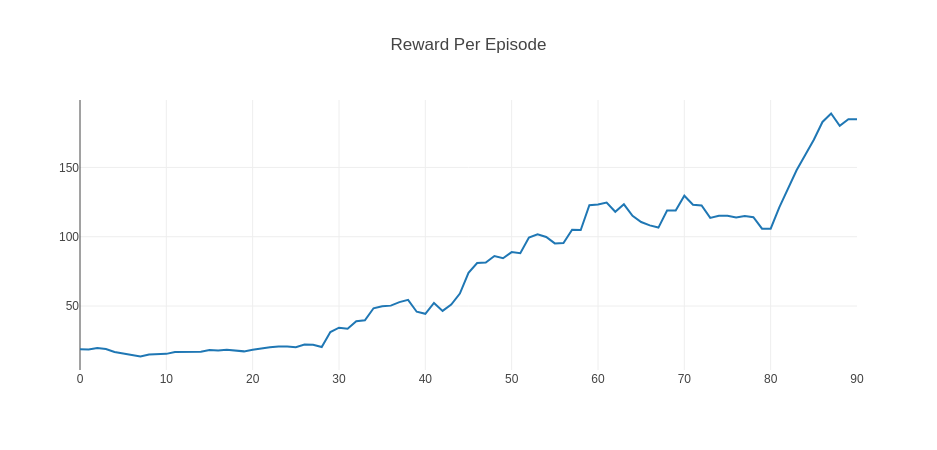

In [27]:
plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(ep_rewards)), y=moving_average(ep_rewards, 10))],
    "layout": go.Layout(title="Reward Per Episode")
})